In [1]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import io
import requests
import urllib
import json
from datetime import datetime
from datetime import timedelta
from urllib.parse import urlencode
from calendar import monthrange
from operator import attrgetter

In [2]:
# Loading data for analysis
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stasov/For Github/olist_customers_dataset.csv')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stasov/For Github/olist_orders_dataset.csv')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stasov/For Github/olist_order_items_dataset.csv')

In [3]:
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [4]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [5]:
items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [6]:
# we see 160 unconfirmed orders, as well as many missed delivery dates, this is normal, because
# there are statuses such as shipped, delivered, which means it’s ok
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

# Step 1. How many users do we have who made a purchase only once?

For this task, we need to merge orders and customers using the customer_id column

Then we will group the new DF by clients and number of orders, and then using the query == 1 method we will leave only those we need.

Also we need to determine what is considered a purchase.

In [7]:
# merging orders and customers
orders_with_customers = orders.merge(customers, on='customer_id', how='left')

In [8]:
orders_with_customers.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP


In [9]:
# look at the missing lines
orders_with_customers.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [10]:
# look at statuses
orders_with_customers.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Here we see that for each order there is a delivery date, for 160 customers there is no confirmation date.

Logically, confirmation of payment should be considered a purchase.

Accordingly, we exclude 160 unconfirmed orders.

We must also exclude "canceled"

It is also important to take exactly "customer_unique_id", since logically 1 "customer_unique_id" can have several "customer_ids"

In [11]:
# leave information containing the date of confirmation of payment
both_one_time = orders_with_customers[orders_with_customers['order_approved_at'].notna()]

In [12]:
# display the final table
both_one_time \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at':'count'}) \
    .query('order_approved_at == 1')

,customer_unique_id,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,1
95993,fffea47cd6d3cc0a88bd621562a9d061,1
95994,ffff371b4d645b6ecea244b27531430a,1
95995,ffff5962728ec6157033ef9805bacc48,1


# Answer: 93049 customers made only 1 purchase

# Step 2. How many orders per month on average are not delivered for various reasons (detail the reasons)?

Here we are interested in 2 statuses: "unavailable" and "canceled", since the remaining statuses "not delivered" are in progress.

To do this, we need to group the data by these two statuses, calculate the quantity and average.

In [13]:
# convert "order_approved_at" to date
not_delivered = orders_with_customers.copy()
not_delivered['order_approved_at'] = pd.to_datetime(not_delivered['order_approved_at'])

In [14]:
# count the number of months from the first to the last "order_approved_at"
summ_of_month = (not_delivered.order_approved_at.max() - not_delivered.order_approved_at.min()) / np.timedelta64(1, 'M')

In [15]:
# get the number of orders in two statuses
canseled_unavailable = not_delivered \
    .query('order_status in ["unavailable", "canceled"]') \
    .groupby('order_status', as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'count_of_orders'})

In [16]:
# Now in a new column will write the result of dividing count_of_orders by the number of months
canseled_unavailable['mean'] = round(canseled_unavailable.count_of_orders / summ_of_month, 1)

In [17]:
canseled_unavailable

,order_status,count_of_orders,mean
0,canceled,625,26.5
1,unavailable,609,25.8


# Answer: On average, orders with "unavailable" and "canceled" statuses per month are 25.8 and 26.5, respectively

# Step 3. For each product, determine on what day of the week the product is most often purchased.

This time let's take "orders" and "items"

We will isolate the day of the week from the date

In [18]:
# create new df
orders_and_items = orders

In [19]:
# merging it with "items"
orders_and_items = orders_and_items.merge(items, on='order_id', how='left')

In [20]:
orders_and_items = orders_and_items.copy()

In [21]:
# convert "order_approved_at" to date
orders_and_items['order_purchase_timestamp'] = pd.to_datetime(orders_and_items['order_purchase_timestamp'])

In [22]:
# calculate the day of the week for each "order_approved_at"
orders_and_items['weekday'] = orders_and_items['order_purchase_timestamp'].dt.day_name()

In [23]:
# create a table of the number of orders per day of the week
most_popular_week = orders_and_items \
    .groupby(['product_id', 'weekday'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'counts_of_products'}) \
    .sort_values('counts_of_products', ascending=False)

In [24]:
# group again, leaving only the week where "counts_of_products" is maximum and display the final table
most_popular_week_for_products = most_popular_week \
    .groupby(['product_id'], as_index=False).max() \
    .sort_values('counts_of_products', ascending=False)

print(most_popular_week_for_products)

                             product_id    weekday  counts_of_products
8613   422879e10f46682990de24d770e7f83d  Wednesday                  93
19742  99a4788cb24856965c36a24e339b6058  Wednesday                  92
22112  aca2eb7d00ea1a7b8ebd4e68314663af  Wednesday                  89
10867  53b36df67ebb7c41585e8d54d6772e08  Wednesday                  76
7079   368c6c730842d78016ad823897a372db  Wednesday                  67
...                                 ...        ...                 ...
12761  62b07aff118f62756ee579afeedc3eb0  Wednesday                   1
12760  62ae6a8f5789aec14529a277c7516def     Sunday                   1
12758  62abef05dddbd149514e4339c84f7d7d     Sunday                   1
12757  62a6991adbb1e60f5c03a77fae5568ff    Tuesday                   1
32950  fffe9eeff12fcbd74a2f2b007dde0c58  Wednesday                   1

[32951 rows x 3 columns]


# Step 4. How many purchases does each user have on average per week (by month)? Do not forget that there may not be a whole number of weeks within a month. For example, November 2021 has 4.28 weeks. And this needs to be taken into account within the metric.

In [25]:
# take our df from task 2
step_4 = orders_with_customers.copy()

In [26]:
# convert the data type to "datetime"
step_4['order_purchase_timestamp'] = pd.to_datetime(step_4['order_purchase_timestamp'])

In [27]:
# leave only the columns we need
step_4 = step_4[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [28]:
# convert "order_purchase_timestamp" to month and year
step_4['month_of_year'] = step_4['order_purchase_timestamp'].dt.to_period('M')

In [29]:
# group data to determine the number of purchases for each unique customer
orders_by_month = step_4.groupby(['customer_unique_id', 'month_of_year'], as_index=False) \
                    .agg({'order_id': 'count'}) \
                    .rename(columns = {'order_id': 'orders_by_month'})

In [30]:
# count the number of weeks in each month
orders_by_month['count_of_weeks_in_month'] = round((orders_by_month['month_of_year'].dt.daysinmonth)/7, 2)

In [31]:
# divide the number of orders by the number of weeks in the month, round to 2 digits
orders_by_month['orders_by_week'] = round(orders_by_month.orders_by_month / orders_by_month.count_of_weeks_in_month, 2)

In [32]:
# get the resulting table sorted from largest to smallest
orders_by_month.sort_values('orders_by_week', ascending=False)                           

,customer_unique_id,month_of_year,orders_by_month,count_of_weeks_in_month,orders_by_week
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.43,1.35
23943,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.00,1.00
69396,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,4.00,1.00
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.00,1.00
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,4.29,0.93
...,...,...,...,...,...
34289,592de7c5eef333c04b18e949537061a8,2017-11,1,4.29,0.23
34287,592d090bb075fa8fb9d6aa816a3ed86d,2017-11,1,4.29,0.23
34286,592c7258a277ceae66e32188e8ef0d79,2017-12,1,4.43,0.23
34285,592c4dd3ead25442e70463fb76c466e8,2018-01,1,4.43,0.23


# Step 5. Conduct a cohort analysis of users. In the period from January to December, identify the cohort with the highest retention in the 3rd month.

Let us determine the sign of cohort formation - the first purchases made in one time interval (month)

We will use only the data in which the payment was made, and exclude "canseled" and "unavailable".

In [33]:
step_5 = orders_with_customers.copy()

In [34]:
# remove statuses that we don’t need
step_5 = step_5.query('order_status not in ["unavailable", "canceled"]').copy()

In [35]:
# convert to "datetime" data type without time
step_5['order_purchase_timestamp'] = pd.to_datetime(step_5['order_purchase_timestamp']).values.astype('datetime64[D]')

In [36]:
# extract month and year
step_5['order_month'] = step_5['order_purchase_timestamp'].dt.to_period('M')

In [37]:
# leave only the columns we need
step_5_task = step_5[['customer_unique_id', 'order_month']]

In [38]:
# create a new column with the first purchase
step_5_task = step_5_task.assign(cohort = step_5_task.groupby('customer_unique_id')['order_month'].transform('min'))

In [39]:
# we see that only 2017 is from January to December
step_5_task.order_month.value_counts().sort_index()

2016-09       2
2016-10     293
2016-12       1
2017-01     787
2017-02    1718
2017-03    2617
2017-04    2377
2017-05    3640
2017-06    3205
2017-07    3946
2017-08    4272
2017-09    4227
2017-10    4547
2017-11    7423
2017-12    5620
2018-01    7187
2018-02    6625
2018-03    7168
2018-04    6919
2018-05    6833
2018-06    6145
2018-07    6233
2018-08    6421
2018-09       1
Freq: M, Name: order_month, dtype: int64

In [40]:
# find out the number of clients in each cohort
step_5_task_cohorts = step_5_task \
    .groupby(['cohort', 'order_month'], as_index=False) \
    .agg({'customer_unique_id':'nunique'}) \
    .rename(columns={'customer_unique_id':'count_of_customers'})

In [41]:
# Using "attrgetter" we calculate when a repeat purchase was made
step_5_task_cohorts['period'] = (step_5_task_cohorts.order_month - step_5_task_cohorts.cohort).apply(attrgetter('n')) 

In [42]:
# combine everything into pivot
step_5_task_cohorts_pivot = step_5_task_cohorts.pivot(index='cohort', columns='period', values='count_of_customers')

In [43]:
step_5_task_cohorts

,cohort,order_month,count_of_customers,period
0,2016-09,2016-09,2,0
1,2016-10,2016-10,290,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11
...,...,...,...,...
215,2018-06,2018-08,16,2
216,2018-07,2018-07,6016,0
217,2018-07,2018-08,31,1
218,2018-08,2018-08,6209,0


In [44]:
# To find out retention we need to divide each value by the cohort size and multiply by 100 to get %
step_5_task_cohorts_pivot = step_5_task_cohorts_pivot.div(step_5_task_cohorts_pivot[0], axis='index')*100

In [45]:
# display the table
step_5_task_cohorts_pivot \
    .style.set_caption('Analysis_of_cohorts') \
    .highlight_max(axis=0, color='orange') \
    .format("{:.2f}", subset=step_5_task_cohorts_pivot.columns, na_rep="")

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00,,,,,,,,,,,,,,,,,,,
2016-10,100.00,,,,,,0.34,,,0.34,,0.34,,0.34,,0.34,,0.34,0.69,0.69
2016-12,100.00,100.00,,,,,,,,,,,,,,,,,,
2017-01,100.00,0.40,0.27,0.13,0.40,0.13,0.40,0.13,0.13,,0.40,0.13,0.66,0.40,0.13,0.13,0.27,0.40,0.13,
2017-02,100.00,0.24,0.30,0.12,0.41,0.12,0.24,0.18,0.12,0.18,0.12,0.30,0.12,0.18,0.12,0.06,0.06,0.24,,
2017-03,100.00,0.51,0.35,0.39,0.35,0.16,0.16,0.31,0.35,0.08,0.39,0.12,0.23,0.12,0.16,0.23,0.08,0.16,,
2017-04,100.00,0.60,0.22,0.17,0.30,0.26,0.34,0.30,0.30,0.17,0.26,0.09,0.09,0.04,0.09,0.09,0.13,,,
2017-05,100.00,0.48,0.48,0.40,0.31,0.34,0.42,0.14,0.25,0.25,0.25,0.34,0.25,0.03,0.20,0.23,,,,
2017-06,100.00,0.45,0.35,0.39,0.26,0.39,0.35,0.23,0.13,0.23,0.32,0.32,0.16,0.13,0.19,,,,,


# Ответ: The maximum retention for 3 months was observed in the cohort of clients who made their first purchase in 2017-05 and amounted to 0.4%

# Step 6. Build RFM user segmentation to qualitatively assess audience.

First we need to create a dataframe with the necessary metrics:
    
     - time from the user’s last purchase to the current date
     - the total number of purchases from the user for the entire time
     - total purchases for the entire time
    
Next, we will assign ranks for each buyer according to three metrics and find out the final rating, which we will give describtion

In [46]:
# merge 2 dataframes
items_orders = items.merge(orders, on='order_id')

In [47]:
# merge with dataframe 3 by "customer_id"
common_df = items_orders.merge(customers, on='customer_id')

In [48]:
# Now let’s sort our main df so that the "order_status" does not have "canceled" and "unavailable", and there is also payment confirmation
common_df = common_df.query('order_status not in ["canceled", "unavailable"] and order_approved_at.notna()')

In [49]:
# select only the columns we need
common_df = common_df[['customer_unique_id', 'order_purchase_timestamp', 'order_id', 'price']].copy()

In [50]:
# convert the data type to datetime
common_df['order_purchase_timestamp'] = pd.to_datetime(common_df['order_purchase_timestamp']).values.astype('datetime64[D]')

As we remember, our date interval is about 2 years, and we need 365

So we need to look at which continuous sales cycle of 365 days we had the most purchases

In [51]:
(common_df.order_purchase_timestamp.max() - common_df.order_purchase_timestamp.min())

Timedelta('729 days 00:00:00')

In [52]:
# highest number of purchases at the end of the observed period and ends 2018-08
# from this month we must limit 365 days
common_df['order_purchase_timestamp'].dt.to_period('M').value_counts().sort_index()

2016-09       5
2016-10     342
2016-12       1
2017-01     951
2017-02    1923
2017-03    2975
2017-04    2660
2017-05    4106
2017-06    3571
2017-07    4493
2017-08    4882
2017-09    4815
2017-10    5300
2017-11    8626
2017-12    6300
2018-01    8173
2018-02    7597
2018-03    8195
2018-04    7957
2018-05    7898
2018-06    7060
2018-07    7039
2018-08    7216
2018-09       1
Freq: M, Name: order_purchase_timestamp, dtype: int64

In [53]:
# limit at the upper limit
common_df = common_df[common_df['order_purchase_timestamp'].dt.strftime('%Y-%m') <= '2018-08']

In [54]:
# calculate the month for the lower limit
common_df.order_purchase_timestamp.max() - timedelta(days=365)

Timestamp('2017-08-29 00:00:00')

In [55]:
# limit the initial month, result in an interval of 365 days
common_df = common_df[common_df['order_purchase_timestamp'].dt.strftime('%Y-%m-%d') > '2017-08-29']

In [56]:
common_df.head()

,customer_unique_id,order_purchase_timestamp,order_id,price
0,871766c5855e863f6eccc05f988b23cb,2017-09-13,00010242fe8c5a6d1ba2dd792cb16214,58.90
2,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,000229ec398224ef6ca0657da4fc703e,199.00
3,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,00024acbcdf0a6daa1e931b038114c75,12.99
6,635d9ac1680f03288e72ada3a1035803,2017-12-10,00054e8431b9d7675808bcb819fb4a32,19.90
7,fda4476abb6307ab3c415b7e6d026526,2018-07-04,000576fe39319847cbb9d288c5617fa6,810.00


In [57]:
# find out the purchase amount for each unique client, but at the same time retain the main columns
grouped_common_df = common_df \
    .groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False) \
    .agg({'price':'sum'})

In [58]:
grouped_common_df.head(2)

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.9
1,000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.0


In [59]:
# To calculate the time since the first purchase, will take the figurative date of uploading the report on the next day
date_of_report = common_df.order_purchase_timestamp.max() + timedelta(days=1)
date_of_report

Timestamp('2018-08-30 00:00:00')

In [60]:
# add a column "days_after_buy"
grouped_common_df['days_after_buy'] = date_of_report - grouped_common_df.order_purchase_timestamp

In [61]:
grouped_common_df.head(2)

,order_id,order_purchase_timestamp,customer_unique_id,price,days_after_buy
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.9,351 days
1,000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.0,228 days


In [62]:
# will find the minimum number of days between the purchase and the day of unloading, 
# the amount of purchases and the amount of orders
common_rfm = grouped_common_df \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg({'days_after_buy':'min', 'order_purchase_timestamp':'count', 'price':'sum'}) \
    .rename(columns={'days_after_buy':'recency', 'order_purchase_timestamp':'frequency', 'price':'monetary'}) \
    .sort_values('monetary', ascending=False)
    

In [63]:
# convert recency to int64 data type
common_rfm['recency'] = common_rfm['recency'].dt.days

In [64]:
common_rfm.head()

,customer_unique_id,recency,frequency,monetary
2858,0a0a92112bd4c708ca5fde585afaa872,335,1,13440.0
33985,763c8b1c9c68a0229c42c9fc6f662b93,46,1,7160.0
20009,459bef486812aa25204be022145caa62,36,1,6729.0
18438,4007669dec559734d6f53e029e360987,279,1,5934.6
20953,48e1ac109decbb87765a3eade6854098,69,1,4590.0


Now we will assign ranks to each buyer and calculate the boundaries of the metrics using quantile.

Using quintiles is more flexible because the ranges will adapt to the data

In [65]:
# display the quantiles of three columns
# quantiles of the frequency metric are all equal to 1, since the overwhelming number of customers made only 1 purchase
# The quantile will be insensitive, so we will classify all customers who made only 1 purchase as rank 1
quantiles = common_rfm[['recency', 'frequency', 'monetary']].quantile([.3, .6]).to_dict()
quantiles

{'recency': {0.3: 110.0, 0.6: 205.0},
 'frequency': {0.3: 1.0, 0.6: 1.0},
 'monetary': {0.3: 53.9, 0.6: 109.99}}

In [66]:
# see fatal differences in the number of purchases for customers
common_rfm.frequency.value_counts()

1     71784
2      1728
3        98
4        17
5         5
7         3
11        1
9         1
Name: frequency, dtype: int64

In [67]:
def r_score(x):                         
    if x <= quantiles['recency'][.3]:
        return 3
    elif x <= quantiles['recency'][.6]:
        return 2
    else:
        return 1
# here, the higher the rank, the less time has passed since the last purchase until unloading


def f_score(x):                                         
    if x <= 1:                  
        return 1
    elif x <= 3:                  
        return 2
    else:                         
        return 3 
# here, the more purchases a client makes, the higher his rank, rank 1 for those clients who made only 1 purchase
    
    
def m_score(x):                         
    if x <= quantiles['monetary'][.3]:
        return 1
    elif x <= quantiles['monetary'][.6]:
        return 2
    else:
        return 3 
# here the buyer’s rank is higher, the larger the amount of purchases he made



In [68]:
# create new columns with corresponding rank values
common_rfm['R'] = common_rfm['recency'].apply(lambda x: r_score(x))
common_rfm['F'] = common_rfm['frequency'].apply(lambda x: f_score(x))
common_rfm['M'] = common_rfm['monetary'].apply(lambda x: m_score(x))

In [69]:
# calculate FRM values for each buyer
common_rfm['rfm_score'] = common_rfm['R'].astype(str) + common_rfm['F'].astype(str) + common_rfm['M'].astype(str)

In [70]:
common_rfm

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_score
2858,0a0a92112bd4c708ca5fde585afaa872,335,1,13440.00,1,1,3,113
33985,763c8b1c9c68a0229c42c9fc6f662b93,46,1,7160.00,3,1,3,313
20009,459bef486812aa25204be022145caa62,36,1,6729.00,3,1,3,313
18438,4007669dec559734d6f53e029e360987,279,1,5934.60,1,1,3,113
20953,48e1ac109decbb87765a3eade6854098,69,1,4590.00,3,1,3,313
...,...,...,...,...,...,...,...,...
59680,cf3839da0d9492ad151690b65f45d800,209,1,2.99,1,1,1,111
54473,bd06ce0e06ad77a7f681f1a4960a3cc6,351,1,2.29,1,1,1,111
14242,317cfc692e3f86c45c95697c61c853a6,5,1,2.20,3,1,1,311
51756,b38211bd797f4fdd81a98b9d1754b606,128,1,0.85,2,1,1,211


In [71]:
# count the number of segments
common_rfm.rfm_score.nunique()

21

In [72]:
# Let's see how we will add comments to "rfm_score"
common_rfm.rfm_score.value_counts().sort_index(ascending=True)

111     8747
112     8970
113    10991
121       26
122      123
123      450
133        4
211     6696
212     6184
213     8583
221       36
222      110
223      444
233       10
311     6756
312     6399
313     8458
321       32
322      117
323      488
333       13
Name: rfm_score, dtype: int64

# Create describtion rfm_score

Top customers - bought recently, a lot, and more than once - 333, 323, 233, 313 (yes, for us more than 1 purchase is already a lot)

Loyal customers - bought quite recently, several times, for a large amount - 322, 223, 222, 213

Ordnary customers - bought not so long ago, but not much, and not often - 211, 212, 221, 312,

Potencial lost customers - bought a long time ago, but more than once, and for a good amount - 123, 133, 122, 123, 113, 112, they need to be stimulated

Lost customers - bought a long time ago, 1 time, a long time ago, for a small amount - 111 however you can also work with them, because they know about our company


In [73]:
# create a description function rfm_score
def describtion(df):
    if df['rfm_score'] in ['111']:
        return 'Lost customers'
    elif df['rfm_score'] in ['123', '133', '122', '123', '113', '112']:
        return 'Potencial lost customers'
    elif df['rfm_score'] in ['211', '212', '221', '312']:
        return 'Ordnary customers'
    elif df['rfm_score'] in ['322', '223', '222', '213']:
        return 'Loyal customers'
    elif df['rfm_score'] in ['333', '323', '233', '313']:
        return 'Top customers'
    else:
        return 'error'

In [74]:
common_rfm['describtion'] = common_rfm.apply(describtion, axis=1)

In [75]:
# get customer descriptions
common_rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_score,describtion
2858,0a0a92112bd4c708ca5fde585afaa872,335,1,13440.0,1,1,3,113,Potencial lost customers
33985,763c8b1c9c68a0229c42c9fc6f662b93,46,1,7160.0,3,1,3,313,Top customers
20009,459bef486812aa25204be022145caa62,36,1,6729.0,3,1,3,313,Top customers
18438,4007669dec559734d6f53e029e360987,279,1,5934.6,1,1,3,113,Potencial lost customers
20953,48e1ac109decbb87765a3eade6854098,69,1,4590.0,3,1,3,313,Top customers


# We can also, together with the marketing department, work out a more relevant  the describtion for the needs of the sales department and management, for example

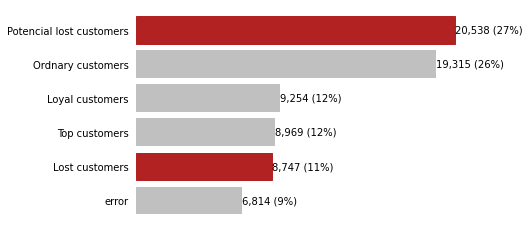

In [76]:
# Finally, let's build a graphic
segments_counts = common_rfm['describtion'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Potencial lost customers', 'Lost customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

# Thus, we see that we have a large percentage of potentially lost customers; we need to take steps to attract them to repurchase. There are also a large number of average buyers in terms of importance and contribution, and not many who buy constantly. Depending on the company’s business goals, we can develop plans for the implementation of any promotions, alerts, etc. for certain groups of buyers and more effectively prioritize resources and funds for implementation. Thank you for your attention:)

